# Modeling
Goal: Use model to predict vacancy rates for 2019-2020

In [15]:
#imports
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
import datetime
from pandas_profiling import ProfileReport
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from xgboost import XGBClassifier

## Introduction
In this notebook, we will make the final predictions for vacancy rate for the years 2019-2020 using the model created in notebook 4.3

In [16]:
#load data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/data/processed'
os.chdir(path) 
# subset data into 2014-2018 to create model and 2019-2020 to do final predictions of vacancy rates during that time
df = pd.read_csv('VacancyRate_Zillow_2014_2018')
df19_20 = pd.read_csv('VacancyRate_Zillow_2019_2020')

In [17]:
df

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,State_AL,State_AR,State_AZ,State_CA,...,CountyName_Weber County,CountyName_Weld County,CountyName_Westchester County,CountyName_Will County,CountyName_Williamson County,CountyName_Wilson County,CountyName_Worcester County,CountyName_Yamhill County,CountyName_Yolo County,CountyName_York County
0,10025,3041.83,2014,0.0,968761.75,9.011810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60657,1589.42,2014,1.0,450755.75,8.042922,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10023,3186.67,2014,2.0,1024543.17,19.964756,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77494,1807.33,2014,3.0,322032.00,3.319292,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60614,1786.25,2014,4.0,580250.92,8.468203,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16143,2110,4643.58,2018,14752.0,1363870.08,17.412045,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16144,20004,2432.25,2018,15149.0,480942.83,21.036585,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16145,80951,1537.18,2018,15318.0,276619.83,1.084746,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16146,11964,20122.17,2018,17169.0,1000069.25,62.044105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#add leading zeros to zipcode
df['Zipcode'] = df['Zipcode'].apply(lambda x: '{0:0>5}'.format(x))
df19_20['Zipcode'] = df19_20['Zipcode'].apply(lambda x: '{0:0>5}'.format(x))

In [19]:
#change Zipcode from ojbect to integer
df.Zipcode = df.Zipcode.astype('int')
df19_20.Zipcode = df19_20.Zipcode.astype('int')
df.dtypes

Zipcode                          int64
RentPrice                      float64
Year                             int64
SizeRank                       float64
HomePrice                      float64
                                ...   
CountyName_Wilson County         int64
CountyName_Worcester County      int64
CountyName_Yamhill County        int64
CountyName_Yolo County           int64
CountyName_York County           int64
Length: 1754, dtype: object

In [20]:
df

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,State_AL,State_AR,State_AZ,State_CA,...,CountyName_Weber County,CountyName_Weld County,CountyName_Westchester County,CountyName_Will County,CountyName_Williamson County,CountyName_Wilson County,CountyName_Worcester County,CountyName_Yamhill County,CountyName_Yolo County,CountyName_York County
0,10025,3041.83,2014,0.0,968761.75,9.011810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60657,1589.42,2014,1.0,450755.75,8.042922,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10023,3186.67,2014,2.0,1024543.17,19.964756,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77494,1807.33,2014,3.0,322032.00,3.319292,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60614,1786.25,2014,4.0,580250.92,8.468203,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16143,2110,4643.58,2018,14752.0,1363870.08,17.412045,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16144,20004,2432.25,2018,15149.0,480942.83,21.036585,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16145,80951,1537.18,2018,15318.0,276619.83,1.084746,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16146,11964,20122.17,2018,17169.0,1000069.25,62.044105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load Model

In [21]:
#define variable X, y
X = df.drop('Vacancy_Rate%', axis=1)
y = df['Vacancy_Rate%']

In [22]:
#split data for test purposes
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [23]:
#load model
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/models'
os.chdir(path)
filename = 'random_forest_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
#test it worked
result = loaded_model.score(X_test, y_test)
print(result)

0.922208934205951


## Refit Model On All Available Data

In [24]:
loaded_model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [161]:
#perform 5 fold cross validation on all available data
cv_results = cross_validate(loaded_model, X, y, cv=5, n_jobs=-1)

In [162]:
#get R2 scores from cross validation
cv_scores = cv_results['test_score']
cv_scores

array([0.91043894, 0.96673606, 0.97035355, 0.96788022, 0.92274149])

In [163]:
#get mean/std of cv test scores
np.mean(cv_scores), np.std(cv_scores)

(0.9476300529044828, 0.025667430198232713)

In [13]:
#get mean/std of mae 
rf_neg_mae = cross_validate(loaded_model, X, y, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [14]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(1.1545411182306395, 0.2513702265613337)

## Calculate Expected Vacacny Rate for 2019-2020 From The Model

In [25]:
#check NaNs
df19_20.isna().sum()

Zipcode             0
RentPrice           0
Year                0
SizeRank            8
State               6
City                6
Metro               6
CountyName          6
HomePrice           8
Vacancy_Rate%    6486
dtype: int64

In [26]:
#drop NaN rows, for only the rows where vacacny is NOT NaN
df19_20.dropna(subset=['SizeRank', 'State', 'City', 'Metro', 'CountyName', 'HomePrice'], inplace=True)

In [27]:
#check NaNs are dealt with correctly
df19_20.isna().sum()

Zipcode             0
RentPrice           0
Year                0
SizeRank            0
State               0
City                0
Metro               0
CountyName          0
HomePrice           0
Vacancy_Rate%    6478
dtype: int64

In [28]:
#create X and y variables for years 2019-2020
X_19_20 = df19_20.drop('Vacancy_Rate%', axis=1)
y_19_20 = df19_20['Vacancy_Rate%']

In [29]:
#turn categorical variables into binary for predicting with get dummies
X_19_20_dummy = pd.get_dummies(X_19_20)

In [30]:
#loaded_model.score(X_19_20, y_19_20)

In [31]:
#predict the vacancy rates for 2019-2020
pred_19_20 = loaded_model.predict(X_19_20_dummy)

In [32]:
pred_19_20

array([12.7747686 ,  8.10552888, 19.20296202, ...,  1.29096648,
       58.89824506, 11.19134688])

In [33]:
#add 2019-2020 vacancy rate data to rest of 2019-2020 dataframe
X_19_20['Vacancy_Rate%'] = pred_19_20
predictions_2019_20 = X_19_20
predictions_2019_20

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%
0,10025,3241.00,2019,0.0,NY,New York,New York-Newark-Jersey City,New York County,1072056.17,12.774769
1,60657,1784.58,2019,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,490717.08,8.105529
2,10023,3354.83,2019,2.0,NY,New York,New York-Newark-Jersey City,New York County,1053399.33,19.202962
3,77494,1795.08,2019,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,341633.50,3.804865
4,60614,2026.42,2019,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,639591.75,8.144044
...,...,...,...,...,...,...,...,...,...,...
6481,2110,4408.57,2020,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1339232.44,18.857168
6482,20004,2505.56,2020,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,497022.00,22.842412
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.290966
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,58.898245


## Explore 2019-2020 Vacancy Rate Data

In [35]:
#get number of unique States in 2019-2020 Vacancy Rate Data
predictions_2019_20.State.nunique()

43

In [36]:
#get list of unique States by percent of total
predictions_2019_20.State.value_counts()/len(predictions_2019_20)*100

CA    16.455696
FL    14.294535
TX     8.799012
NY     4.353195
VA     4.322322
AZ     4.260574
IL     4.106206
GA     3.890090
WA     3.087373
NC     2.994751
MD     2.933004
CO     2.778635
NJ     2.655140
PA     2.377277
MA     2.161161
MI     1.914171
TN     1.728929
MO     1.667181
NV     1.605434
OH     1.574560
MN     1.481939
SC     1.481939
CT     1.451065
OR     1.204075
IN     0.895338
OK     0.617475
DC     0.555727
HI     0.524853
ID     0.493980
WI     0.370485
KY     0.339611
KS     0.339611
UT     0.339611
LA     0.308737
RI     0.308737
AL     0.277864
NM     0.277864
DE     0.246990
NE     0.216116
IA     0.092621
NH     0.092621
MS     0.092621
AR     0.030874
Name: State, dtype: float64

In [37]:
#Missing States:
#AK, ME, MT, ND, SD, VT, WV, WY

In [47]:
#split 2019-2020 data into separate years
#for more specific analysis
predictions_2019 = predictions_2019_20[predictions_2019_20.Year == 2019]
predictions_2020 = predictions_2019_20[predictions_2019_20.Year == 2020]
predictions_2019

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%
0,10025,3241.00,2019,0.0,NY,New York,New York-Newark-Jersey City,New York County,1072056.17,12.774769
1,60657,1784.58,2019,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,490717.08,8.105529
2,10023,3354.83,2019,2.0,NY,New York,New York-Newark-Jersey City,New York County,1053399.33,19.202962
3,77494,1795.08,2019,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,341633.50,3.804865
4,60614,2026.42,2019,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,639591.75,8.144044
...,...,...,...,...,...,...,...,...,...,...
3238,2110,4718.58,2019,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1364140.92,18.489806
3239,20004,2454.67,2019,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,483746.17,22.842412
3240,80951,1603.91,2019,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,292574.83,1.108472
3241,11964,17439.00,2019,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1019944.42,60.623847


In [48]:
#sort all 2020 zipcodes by vacancy rate
predictions_2020.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%
6464,11978,40654.00,2020,11537.0,NY,Westhampton Beach,New York-Newark-Jersey City,Suffolk County,1171179.44,67.367599
5455,34747,1575.78,2020,4108.0,FL,Citrus Ridge,Orlando-Kissimmee-Sanford,Osceola County,277538.78,67.338278
6396,89109,2030.67,2020,9205.0,NV,Las Vegas,Las Vegas-Henderson-Paradise,Clark County,303027.67,65.174719
6213,34242,3119.20,2020,6962.0,FL,Siesta Key,North Port-Sarasota-Bradenton,Sarasota County,635396.78,64.258612
6479,11976,36116.00,2020,14009.0,NY,Water Mill,New York-Newark-Jersey City,Suffolk County,2869004.11,60.980663
...,...,...,...,...,...,...,...,...,...,...
5742,7430,2185.22,2020,4958.0,NJ,Mahwah Township,New York-Newark-Jersey City,Bergen County,475482.11,2.295860
6268,78739,2641.89,2020,7354.0,TX,Austin,Austin-Round Rock,Travis County,551864.89,2.090390
6323,95391,2649.00,2020,7967.0,CA,Tracy,Stockton-Lodi,San Joaquin County,661270.11,1.902002
6347,19096,1838.78,2020,8249.0,PA,Wynnewood,Philadelphia-Camden-Wilmington,Montgomery County,565340.67,1.845831


In [49]:
#look at states grouped by avg vacancy rate
state_groups = predictions_2020.groupby(['State']).mean()
state_groups.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%
State,,,,,,
LA,70253.700000,1452.822000,2020.0,3564.000000,335594.409000,17.242669
FL,33397.909287,1714.403175,2020.0,3686.624190,282784.038531,16.898550
RI,2880.300000,1702.075000,2020.0,3805.100000,339608.178000,13.050832
NV,89108.153846,1416.171538,2020.0,3021.019231,295219.265000,12.751589
NY,11001.468085,4041.434894,2020.0,3378.063830,748244.463262,12.133991
AZ,85278.268116,1480.093551,2020.0,2998.152174,318899.116739,12.121655
AR,72205.000000,952.000000,2020.0,3580.000000,174018.440000,10.689449
OH,44176.980392,1137.472941,2020.0,2737.039216,178799.431373,10.088993
DE,19780.625000,1413.081250,2020.0,3554.000000,217653.166250,10.040015


In [50]:
#look at County Names grouped by avg vacancy rate
county_groups = predictions_2020.groupby(['CountyName']).mean()
county_groups.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%
CountyName,,,,,,
Osceola County,34637.750000,1632.111250,2020.0,3628.000000,250313.486250,33.501994
El Dorado County,95956.000000,2004.890000,2020.0,3695.000000,562876.665000,26.962358
Sarasota County,34251.750000,1946.546500,2020.0,5136.650000,323782.827000,25.097164
Lee County,33962.941176,1645.269412,2020.0,3989.000000,237688.725882,24.805492
Martin County,34984.500000,1891.827500,2020.0,3089.500000,318070.585000,23.954436
...,...,...,...,...,...,...
Loudoun County,20152.818182,2270.883636,2020.0,4368.636364,558806.223636,3.468960
Dakota County,55161.666667,1587.296667,2020.0,1659.333333,303201.886667,3.302214
Broomfield County,80021.500000,1965.885000,2020.0,3023.500000,543740.280000,3.296678


In [51]:
#look at Metro Area grouped by avg vacancy rate
metro_groups = predictions_2020.groupby(['Metro']).mean()
metro_groups.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%
Metro,,,,,,
Cape Coral-Fort Myers,33962.941176,1645.269412,2020.0,3989.000000,237688.725882,24.805492
North Port-Sarasota-Bradenton,34237.700000,1858.205000,2020.0,4372.666667,304210.458667,23.693933
Port St. Lucie,34975.636364,1793.530000,2020.0,3868.000000,277064.250909,21.339263
Lakeland-Winter Haven,33955.733333,1391.704667,2020.0,3659.800000,196345.281333,18.921408
New Orleans-Metairie,70192.000000,1477.258889,2020.0,3604.777778,348037.343333,18.086490
...,...,...,...,...,...,...
Colorado Springs,80869.571429,1549.760476,2020.0,4688.761905,333060.587619,4.425871
Provo-Orem,84218.000000,1369.886667,2020.0,3717.000000,342798.703333,4.200698
Fort Collins,80529.333333,1616.076667,2020.0,777.333333,407307.850000,3.817849


In [52]:
#look at City grouped by avg vacancy rate
city_groups = predictions_2020.groupby(['City']).mean()
city_groups.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%
City,,,,,,
Westhampton Beach,11978.0,40654.00,2020.0,11537.0,1171179.440,67.367599
Siesta Key,34242.0,3119.20,2020.0,6962.0,635396.780,64.258612
Water Mill,11976.0,36116.00,2020.0,14009.0,2869004.110,60.980663
Longboat Key,34228.0,4370.00,2020.0,6604.0,661044.440,59.040456
Town of Shelter Island,11964.0,15800.50,2020.0,17169.0,1015162.000,58.898245
...,...,...,...,...,...,...
Chantilly,20151.5,2278.50,2020.0,5804.5,586540.555,2.492965
West Jordan,84081.0,1609.56,2020.0,2931.0,392626.330,2.450164
Burke,22015.0,2414.56,2020.0,2302.0,553685.780,2.395728


## Explore 2020 Rent/Price Ratios 
and Rent/Price Ratio adjusted for Vacancy

In [53]:
#calculate rent to price ratio, add as column
predictions_2020['Rent/Price_Ratio%'] = ((predictions_2020['RentPrice']*12)/predictions_2020['HomePrice'])*100
predictions_2020

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%
3243,10025,3146.67,2020,0.0,NY,New York,New York-Newark-Jersey City,New York County,951924.67,12.648444,3.966705
3244,60657,1791.56,2020,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,490915.22,8.105529,4.379314
3245,10023,3268.00,2020,2.0,NY,New York,New York-Newark-Jersey City,New York County,1091064.33,19.609160,3.594289
3246,77494,1811.00,2020,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,343916.44,3.754790,6.318977
3247,60614,2035.44,2020,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,634424.44,8.346243,3.849990
...,...,...,...,...,...,...,...,...,...,...,...
6481,2110,4408.57,2020,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1339232.44,18.857168,3.950236
6482,20004,2505.56,2020,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,497022.00,22.842412,6.049374
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.290966,6.267963
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,58.898245,18.677413


In [54]:
#calculate rent to price ratio adjusted for vacancy
predictions_2020['Rent/PriceRatio_vacancyAdjusted%'] = (((predictions_2020['RentPrice']*12)*((100 - predictions_2020['Vacancy_Rate%']))/100)/predictions_2020['HomePrice'])*100
predictions_2020

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%
3243,10025,3146.67,2020,0.0,NY,New York,New York-Newark-Jersey City,New York County,951924.67,12.648444,3.966705,3.464978
3244,60657,1791.56,2020,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,490915.22,8.105529,4.379314,4.024348
3245,10023,3268.00,2020,2.0,NY,New York,New York-Newark-Jersey City,New York County,1091064.33,19.609160,3.594289,2.889479
3246,77494,1811.00,2020,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,343916.44,3.754790,6.318977,6.081712
3247,60614,2035.44,2020,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,634424.44,8.346243,3.849990,3.528661
...,...,...,...,...,...,...,...,...,...,...,...,...
6481,2110,4408.57,2020,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1339232.44,18.857168,3.950236,3.205333
6482,20004,2505.56,2020,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,497022.00,22.842412,6.049374,4.667551
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.290966,6.267963,6.187046
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,58.898245,18.677413,7.676745


In [55]:
#calculate difference from rent/price and rent/price vacancy adjusted ratios
predictions_2020['diff_Rent/Price_Ratios'] = predictions_2020['Rent/Price_Ratio%'] - predictions_2020['Rent/PriceRatio_vacancyAdjusted%']
predictions_2020

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
3243,10025,3146.67,2020,0.0,NY,New York,New York-Newark-Jersey City,New York County,951924.67,12.648444,3.966705,3.464978,0.501726
3244,60657,1791.56,2020,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,490915.22,8.105529,4.379314,4.024348,0.354967
3245,10023,3268.00,2020,2.0,NY,New York,New York-Newark-Jersey City,New York County,1091064.33,19.609160,3.594289,2.889479,0.704810
3246,77494,1811.00,2020,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,343916.44,3.754790,6.318977,6.081712,0.237264
3247,60614,2035.44,2020,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,634424.44,8.346243,3.849990,3.528661,0.321330
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6481,2110,4408.57,2020,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1339232.44,18.857168,3.950236,3.205333,0.744903
6482,20004,2505.56,2020,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,497022.00,22.842412,6.049374,4.667551,1.381823
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.290966,6.267963,6.187046,0.080917
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,58.898245,18.677413,7.676745,11.000669


In [58]:
#get high/low for rent/price ratios vacancy adjusted  (aka potential strong/weak places to invest)
#sort all 2020 zipcodes by Rent/PriceRatio_vacancyAdjusted%
predictions_2020.sort_values('Rent/PriceRatio_vacancyAdjusted%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
5341,48205,814.78,2020,3788.0,MI,Detroit,Detroit-Warren-Dearborn,Wayne County,29405.78,29.055149,33.249790,23.589014,9.660776
4513,48227,860.00,2020,1972.0,MI,Detroit,Detroit-Warren-Dearborn,Wayne County,36374.67,22.848391,28.371391,21.888985,6.482406
3851,48228,842.25,2020,824.0,MI,Detroit,Detroit-Warren-Dearborn,Wayne County,35956.33,23.170244,28.109098,21.596151,6.512947
5997,43609,819.33,2020,5852.0,OH,Toledo,Toledo,Lucas County,37129.78,20.167516,26.479985,21.139629,5.340355
3963,63136,860.11,2020,1011.0,MO,Jennings,St. Louis,Saint Louis County,40323.33,20.093806,25.596398,20.453107,5.143290
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4005,90049,3293.67,2020,1080.0,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,2770108.22,9.792148,1.426805,1.287090,0.139715
6123,94301,3788.86,2020,6425.0,CA,Palo Alto,San Jose-Sunnyvale-Santa Clara,Santa Clara County,3656731.56,7.629542,1.243360,1.148497,0.094863
4239,94010,2839.78,2020,1483.0,CA,Burlingame,San Francisco-Oakland-Hayward,San Mateo County,2940861.89,7.250605,1.158754,1.074737,0.084017
6165,85253,1617.33,2020,6646.0,AZ,Paradise Valley,Phoenix-Mesa-Scottsdale,Maricopa County,1697045.00,15.054635,1.143633,0.971463,0.172170


In [59]:
#look at states grouped by rent/price ratios vacancy adjusted 
state_groups = predictions_2020.groupby(['State']).mean()
state_groups.sort_values('Rent/PriceRatio_vacancyAdjusted%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
State,,,,,,,,,
MS,38654.000000,1380.296667,2020.0,2375.666667,166809.446667,6.535379,10.421310,9.717295,0.704015
MI,48300.274194,1354.342097,2020.0,3914.145161,209476.851290,7.630877,9.951053,8.940628,1.010425
KY,40378.454545,1100.585455,2020.0,3052.545455,179421.879091,9.791153,9.480814,8.284957,1.195857
OH,44176.980392,1137.472941,2020.0,2737.039216,178799.431373,10.088993,9.213626,8.142020,1.071606
NE,68116.000000,1135.761429,2020.0,5196.000000,169763.682857,8.449288,8.877123,8.082285,0.794837
IN,46179.896552,1240.984138,2020.0,2922.689655,186838.861724,9.549131,8.983934,8.038983,0.944951
DE,19780.625000,1413.081250,2020.0,3554.000000,217653.166250,10.040015,9.024677,7.933005,1.091673
MO,63546.796296,1178.532037,2020.0,4155.814815,195303.586111,9.615167,8.696307,7.695131,1.001176
TN,37628.285714,1406.466964,2020.0,2698.589286,250524.567321,9.588203,8.375894,7.443120,0.932774


In [60]:
#look at County Names grouped by rent/price ratios vacancy adjusted 
county_groups = predictions_2020.groupby(['CountyName']).mean()
county_groups.sort_values('Rent/PriceRatio_vacancyAdjusted%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
CountyName,,,,,,,,,
Lucas County,43610.500000,841.275000,2020.0,4610.000000,5.161422e+04,16.553315,21.075732,17.391679,3.684053
Luzerne County,18702.000000,861.120000,2020.0,1292.000000,6.678200e+04,16.239955,15.473391,12.960519,2.512872
Wayne County,48192.500000,1128.976500,2020.0,3511.400000,1.536570e+05,10.631267,13.874643,11.831948,2.042695
Baltimore City,21217.176471,1403.342941,2020.0,3210.294118,1.531697e+05,18.392573,12.763634,10.088722,2.674912
DeSoto County,38654.000000,1380.296667,2020.0,2375.666667,1.668094e+05,6.535379,10.421310,9.717295,0.704015
...,...,...,...,...,...,...,...,...,...
El Dorado County,95956.000000,2004.890000,2020.0,3695.000000,5.628767e+05,26.962358,4.338198,3.081391,1.256807
Santa Clara County,94855.142857,3303.867500,2020.0,2452.107143,1.485406e+06,4.841616,3.061852,2.922190,0.139662
Marin County,94931.750000,4206.575000,2020.0,5205.750000,1.750789e+06,7.327619,2.956915,2.740394,0.216521


In [61]:
#look at Metro Area grouped by rent/price ratios vacancy adjusted 
metro_groups = predictions_2020.groupby(['Metro']).mean()
metro_groups.sort_values('Rent/PriceRatio_vacancyAdjusted%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
Metro,,,,,,,,,
Toledo,43610.500000,841.275000,2020.0,4610.000000,5.161422e+04,16.553315,21.075732,17.391679,3.684053
Scranton--Wilkes-Barre--Hazleton,18702.000000,861.120000,2020.0,1292.000000,6.678200e+04,16.239955,15.473391,12.960519,2.512872
Dayton,45378.800000,880.266000,2020.0,3912.400000,1.014115e+05,13.555095,11.956396,10.102787,1.853609
Memphis,38158.714286,1200.141429,2020.0,3240.142857,1.573607e+05,11.087558,10.899793,9.516433,1.383360
Detroit-Warren-Dearborn,48194.508772,1363.865263,2020.0,4027.894737,2.102551e+05,7.806258,10.156188,9.095311,1.060877
...,...,...,...,...,...,...,...,...,...
Boulder,80320.857143,2060.397143,2020.0,3255.285714,6.841561e+05,4.965463,3.840957,3.660038,0.180920
Los Angeles-Long Beach-Anaheim,91367.834043,2751.766383,2020.0,3274.370213,9.852084e+05,6.739636,3.791744,3.555714,0.236030
Urban Honolulu,96782.176471,2098.194118,2020.0,1665.176471,6.714232e+05,10.010293,3.851936,3.441003,0.410934


In [62]:
#look at City grouped by rent/price ratios vacancy adjusted 
city_groups = predictions_2020.groupby(['City']).mean()
city_groups.sort_values('Rent/PriceRatio_vacancyAdjusted%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
City,,,,,,,,,
Jennings,63136.0,860.110,2020.0,1011.000000,4.032333e+04,20.093806,25.596398,20.453107,5.143290
Detroit,48223.8,852.116,2020.0,2006.400000,4.088431e+04,21.235908,26.349104,20.435497,5.913607
Hampton Bays,11946.0,13875.000,2020.0,6667.000000,5.848019e+05,33.288275,28.471180,18.993615,9.477565
Northwoods,63121.0,846.000,2020.0,4127.000000,4.308567e+04,20.375684,23.562358,18.761367,4.800992
Park Forest,60466.0,1346.000,2020.0,5230.000000,7.973900e+04,11.945518,20.256085,17.836391,2.419694
...,...,...,...,...,...,...,...,...,...
Laguna Beach,92651.0,3911.330,2020.0,3330.000000,2.378941e+06,18.757892,1.972977,1.602888,0.370089
Beverly Hills,90211.0,5300.890,2020.0,7636.333333,3.308222e+06,14.242608,1.864389,1.591354,0.273035
Los Gatos,95030.0,4015.220,2020.0,8463.000000,2.804401e+06,9.352208,1.718108,1.557427,0.160681


### Explore 2020 Places where Rent/Price Ratio Most Impacted by Vacancy 

In [88]:
#sort all 2020 zipcodes by DIFFERENCE in rent/price ratios AND rent/price ratio adjusted for vacancy
predictions_2020.sort_values('diff_Rent/Price_Ratios', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
6464,11978,40654.00,2020,11537.0,NY,Westhampton Beach,New York-Newark-Jersey City,Suffolk County,1171179.44,67.367599,41.654420,13.592837,28.061582
6480,11977,29018.67,2020,14460.0,NY,Westhampton,New York-Newark-Jersey City,Suffolk County,977930.33,53.119980,35.608267,16.693162,18.915104
6180,11968,31550.17,2020,6718.0,NY,Southampton,New York-Newark-Jersey City,Suffolk County,1459703.00,52.746896,25.936923,12.256001,13.680922
5284,11937,28511.67,2020,3634.0,NY,East Hampton,New York-Newark-Jersey City,Suffolk County,1375317.22,51.271884,24.877173,12.122177,12.754995
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,58.898245,18.677413,7.676745,11.000669
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5124,95120,4116.88,2020,3249.0,CA,San Jose,San Jose-Sunnyvale-Santa Clara,Santa Clara County,1496601.67,2.630975,3.300983,3.214135,0.086848
4239,94010,2839.78,2020,1483.0,CA,Burlingame,San Francisco-Oakland-Hayward,San Mateo County,2940861.89,7.250605,1.158754,1.074737,0.084017
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.290966,6.267963,6.187046,0.080917
4030,94611,2869.44,2020,1130.0,CA,Oakland,San Francisco-Oakland-Hayward,Alameda County,1357979.44,3.077119,2.535626,2.457602,0.078024


In [89]:
#filter this by states
state_groups.sort_values('diff_Rent/Price_Ratios', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
State,,,,,,,,,
FL,33397.909287,1714.403175,2020.0,3686.624190,282784.038531,16.898550,7.809711,6.493200,1.316511
NY,11001.468085,4041.434894,2020.0,3378.063830,748244.463262,12.133991,6.223371,4.986892,1.236479
KY,40378.454545,1100.585455,2020.0,3052.545455,179421.879091,9.791153,9.480814,8.284957,1.195857
DE,19780.625000,1413.081250,2020.0,3554.000000,217653.166250,10.040015,9.024677,7.933005,1.091673
OH,44176.980392,1137.472941,2020.0,2737.039216,178799.431373,10.088993,9.213626,8.142020,1.071606
MI,48300.274194,1354.342097,2020.0,3914.145161,209476.851290,7.630877,9.951053,8.940628,1.010425
MO,63546.796296,1178.532037,2020.0,4155.814815,195303.586111,9.615167,8.696307,7.695131,1.001176
IN,46179.896552,1240.984138,2020.0,2922.689655,186838.861724,9.549131,8.983934,8.038983,0.944951
TN,37628.285714,1406.466964,2020.0,2698.589286,250524.567321,9.588203,8.375894,7.443120,0.932774


In [90]:
#filter by county
county_groups.sort_values('diff_Rent/Price_Ratios', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
CountyName,,,,,,,,,
Lucas County,43610.500000,841.275000,2020.0,4610.000000,5.161422e+04,16.553315,21.075732,17.391679,3.684053
Suffolk County,5604.761905,7401.777381,2020.0,5933.785714,8.085912e+05,17.974273,8.989265,5.936512,3.052752
Baltimore City,21217.176471,1403.342941,2020.0,3210.294118,1.531697e+05,18.392573,12.763634,10.088722,2.674912
Osceola County,34637.750000,1632.111250,2020.0,3628.000000,2.503135e+05,33.501994,7.918435,5.319786,2.598649
Luzerne County,18702.000000,861.120000,2020.0,1292.000000,6.678200e+04,16.239955,15.473391,12.960519,2.512872
...,...,...,...,...,...,...,...,...,...
Loudoun County,20152.818182,2270.883636,2020.0,4368.636364,5.588062e+05,3.468960,4.923658,4.751528,0.172130
Contra Costa County,94582.812500,2753.276875,2020.0,2813.937500,8.088295e+05,3.794253,4.450391,4.280788,0.169603
Broomfield County,80021.500000,1965.885000,2020.0,3023.500000,5.437403e+05,3.296678,4.496261,4.352584,0.143677


In [91]:
#filter by Metro area
metro_groups.sort_values('diff_Rent/Price_Ratios', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
Metro,,,,,,,,,
Toledo,43610.500000,841.275000,2020.0,4610.000000,5.161422e+04,16.553315,21.075732,17.391679,3.684053
Scranton--Wilkes-Barre--Hazleton,18702.000000,861.120000,2020.0,1292.000000,6.678200e+04,16.239955,15.473391,12.960519,2.512872
Cape Coral-Fort Myers,33962.941176,1645.269412,2020.0,3989.000000,2.376887e+05,24.805492,8.549533,6.439683,2.109850
Dayton,45378.800000,880.266000,2020.0,3912.400000,1.014115e+05,13.555095,11.956396,10.102787,1.853609
North Port-Sarasota-Bradenton,34237.700000,1858.205000,2020.0,4372.666667,3.042105e+05,23.693933,7.669476,5.909696,1.759780
...,...,...,...,...,...,...,...,...,...
Provo-Orem,84218.000000,1369.886667,2020.0,3717.000000,3.427987e+05,4.200698,4.738198,4.543501,0.194697
Fort Collins,80529.333333,1616.076667,2020.0,777.333333,4.073078e+05,3.817849,4.778705,4.596586,0.182120
Boulder,80320.857143,2060.397143,2020.0,3255.285714,6.841561e+05,4.965463,3.840957,3.660038,0.180920


In [92]:
#filter by city
city_groups.sort_values('diff_Rent/Price_Ratios', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
City,,,,,,,,,
Westhampton Beach,11978.0,40654.000,2020.0,11537.0,1171179.440,67.367599,41.654420,13.592837,28.061582
Westhampton,11977.0,29018.670,2020.0,14460.0,977930.330,53.119980,35.608267,16.693162,18.915104
Southampton,11968.0,31550.170,2020.0,6718.0,1459703.000,52.746896,25.936923,12.256001,13.680922
East Hampton,11937.0,28511.670,2020.0,3634.0,1375317.220,51.271884,24.877173,12.122177,12.754995
Town of Shelter Island,11964.0,15800.500,2020.0,17169.0,1015162.000,58.898245,18.677413,7.676745,11.000669
...,...,...,...,...,...,...,...,...,...
Cupertino,95014.0,3452.890,2020.0,537.0,2098103.440,5.283444,1.974864,1.870523,0.104341
Los Alamitos,90720.0,2387.220,2020.0,5574.0,1047254.110,3.634574,2.735405,2.635985,0.099420
Redwood City,94061.5,3148.665,2020.0,3649.0,1945891.165,4.928551,1.998727,1.903754,0.094972


## Combine 2014-2018 & 2019-2020 Data for exploration

In [63]:
#load data without dummy variables
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/data/interim'
os.chdir(path) 
df2 = pd.read_csv('vacancy_zillowHomeRent_merge_2014_2020.csv', dtype={'Zipcode': object})
df2.head()

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%,MOE-VacancyRate%
0,10025,3041.83,2014,0.0,NY,New York,New York-Newark-Jersey City,New York County,968761.75,9.011810,1.539867
1,60657,1589.42,2014,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,450755.75,8.042922,1.343734
2,10023,3186.67,2014,2.0,NY,New York,New York-Newark-Jersey City,New York County,1024543.17,19.964756,2.296513
3,77494,1807.33,2014,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,322032.00,3.319292,1.229599
4,60614,1786.25,2014,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,580250.92,8.468203,1.250484


In [64]:
#drop margin of error of vacancy rate
df2.drop('MOE-VacancyRate%', axis=1, inplace=True)

In [65]:
#preserve 2014-2018 data
df2 = df2[df2.Year < 2019]

In [66]:
#check NaNs
df2.isna().sum()/len(df2)*100

Zipcode          0.000000
RentPrice        0.018501
Year             0.000000
SizeRank         0.123343
State            0.092507
City             0.092507
Metro            0.092507
CountyName       0.092507
HomePrice        0.240518
Vacancy_Rate%    0.154178
dtype: float64

In [67]:
#drop NaNs
df2.dropna(inplace=True)

In [68]:
#change zipcode into integer
df2.Zipcode = df2.Zipcode.astype('int')
df2.dtypes

Zipcode            int64
RentPrice        float64
Year               int64
SizeRank         float64
State             object
City              object
Metro             object
CountyName        object
HomePrice        float64
Vacancy_Rate%    float64
dtype: object

In [69]:
#concat 2014-2018 data with 2019-2020
df14_20 = pd.concat([df2, predictions_2019_20])
df14_20

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%
0,10025,3041.83,2014,0.0,NY,New York,New York-Newark-Jersey City,New York County,968761.75,9.011810
1,60657,1589.42,2014,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,450755.75,8.042922
2,10023,3186.67,2014,2.0,NY,New York,New York-Newark-Jersey City,New York County,1024543.17,19.964756
3,77494,1807.33,2014,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,322032.00,3.319292
4,60614,1786.25,2014,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,580250.92,8.468203
...,...,...,...,...,...,...,...,...,...,...
6481,2110,4408.57,2020,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1339232.44,18.857168
6482,20004,2505.56,2020,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,497022.00,22.842412
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.290966
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,58.898245


<AxesSubplot:xlabel='Year', ylabel='Vacancy_Rate%'>

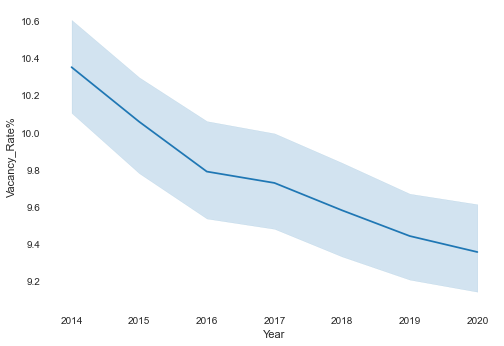

In [70]:
#plot average vacany rate over time
sns.lineplot(data=df14_20, x="Year", y="Vacancy_Rate%")

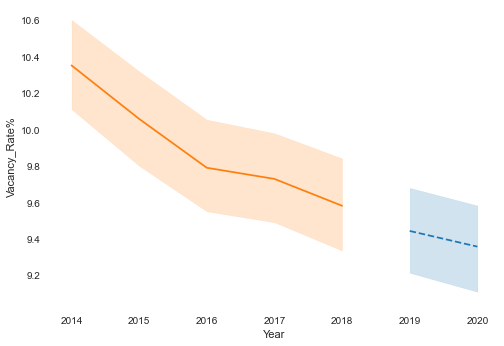

In [71]:
#plot 19-20 data with dotted line
ax = sns.lineplot(data=predictions_2019_20, x="Year", y="Vacancy_Rate%")

# Might need to loop through the list if there are multiple lines on the plot
ax.lines[0].set_linestyle("--")

sns.lineplot(data=df2, x="Year", y="Vacancy_Rate%")

plt.show()

In [72]:
#look at years grouped by avg vacancy rate
year_groups = df14_20.groupby(['Year']).mean()
year_groups.reset_index(inplace=True)
year_groups

,Year,Zipcode,RentPrice,SizeRank,HomePrice,Vacancy_Rate%
0,2014,53908.184472,1540.939537,3196.855280,323535.848193,10.350332
1,2015,53825.279740,1641.556704,3205.623916,343732.276853,10.056811
2,2016,53824.307240,1701.844341,3206.472153,365480.607618,9.788604
3,2017,53810.133271,1756.986478,3205.861163,388186.640025,9.727441
4,2018,53810.133271,1805.311079,3205.861163,414801.991456,9.580019
5,2019,53822.729237,1856.936789,3206.279716,424215.916644,9.441780
6,2020,53822.729237,1889.907984,3206.279716,438340.191575,9.355759


In [73]:
#drop columns not of interest when looking at average per year
year_groups.drop(['Zipcode', 'SizeRank'], axis=1, inplace=True)

<AxesSubplot:xlabel='Year', ylabel='RentPrice'>

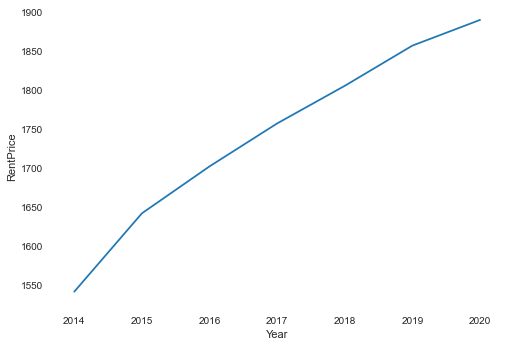

In [74]:
#plot average rent price per year
sns.lineplot(data=year_groups, x="Year", y="RentPrice")

<AxesSubplot:xlabel='Year', ylabel='HomePrice'>

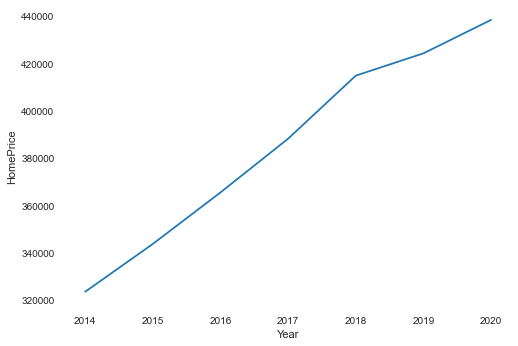

In [75]:
#plot average home price per year
sns.lineplot(data=year_groups, x="Year", y="HomePrice")

<AxesSubplot:xlabel='Year', ylabel='Vacancy_Rate%'>

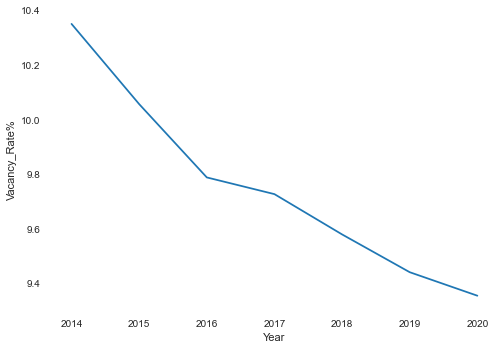

In [76]:
#plot average vacany per year
sns.lineplot(data=year_groups, x="Year", y="Vacancy_Rate%")

In [77]:
#look at std by year
df_std = df14_20.groupby('Year').std()
df_std.reset_index(inplace=True)
df_std.drop(['Zipcode', 'SizeRank'], axis=1, inplace=True)

In [78]:
df_std

,Year,RentPrice,HomePrice,Vacancy_Rate%
0,2014,1786.649568,270087.107257,7.512805
1,2015,2033.172548,294223.503928,7.475292
2,2016,1936.692901,314062.458276,7.446735
3,2017,1991.368197,332753.945356,7.449679
4,2018,1816.755186,362936.496822,7.399814
5,2019,1652.270953,362576.708835,7.003591
6,2020,1524.078903,373208.937008,6.956361


<AxesSubplot:xlabel='Year', ylabel='Vacancy_Rate%'>

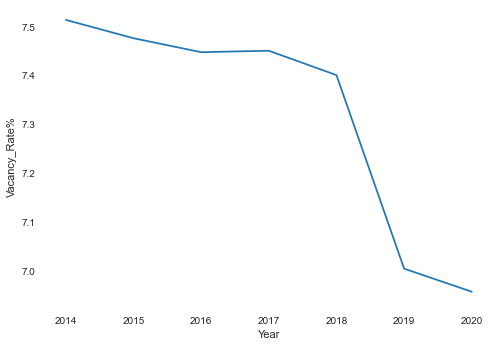

In [79]:
#plot std vacancy rate by year
sns.lineplot(data=df_std, x="Year", y="Vacancy_Rate%")

<AxesSubplot:xlabel='Year', ylabel='RentPrice'>

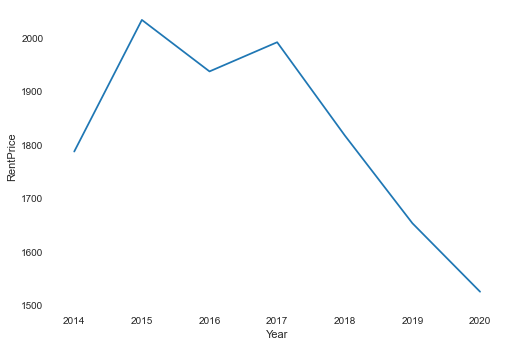

In [80]:
#plot std rent price by year
sns.lineplot(data=df_std, x="Year", y="RentPrice")

<AxesSubplot:xlabel='Year', ylabel='HomePrice'>

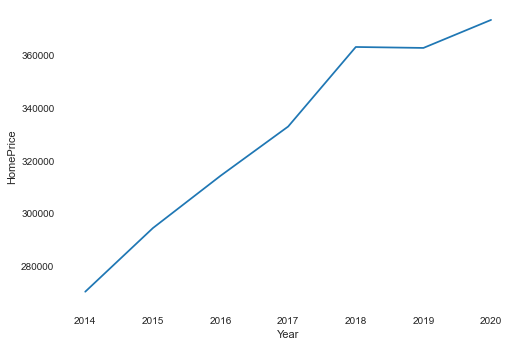

In [81]:
#plot std home price price by year
sns.lineplot(data=df_std, x="Year", y="HomePrice")

## Rent to Price Ratios over Time
Also adjusted for vacancy

In [83]:
#calculate price to rent ratio, add as column
df14_20['Rent/Price_Ratio%'] = ((df14_20['RentPrice']*12)/df14_20['HomePrice'])*100
#calculate price to rent adjusted for vacancy
df14_20['Rent/PriceRatio_vacancyAdjusted%'] = (((df14_20['RentPrice']*12)*((100 - df14_20['Vacancy_Rate%']))/100)/df14_20['HomePrice'])*100
#calculate difference from rent/price and rent/price vacancy adjusted ratios
df14_20['diff_Rent/Price_Ratios'] = df14_20['Rent/Price_Ratio%'] - df14_20['Rent/PriceRatio_vacancyAdjusted%']
df14_20

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%,Rent/Price_Ratio%,Rent/PriceRatio_vacancyAdjusted%,diff_Rent/Price_Ratios
0,10025,3041.83,2014,0.0,NY,New York,New York-Newark-Jersey City,New York County,968761.75,9.011810,3.767899,3.428343,0.339556
1,60657,1589.42,2014,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,450755.75,8.042922,4.231347,3.891023,0.340324
2,10023,3186.67,2014,2.0,NY,New York,New York-Newark-Jersey City,New York County,1024543.17,19.964756,3.732399,2.987235,0.745164
3,77494,1807.33,2014,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,322032.00,3.319292,6.734722,6.511177,0.223545
4,60614,1786.25,2014,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,580250.92,8.468203,3.694092,3.381268,0.312823
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6481,2110,4408.57,2020,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1339232.44,18.857168,3.950236,3.205333,0.744903
6482,20004,2505.56,2020,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,497022.00,22.842412,6.049374,4.667551,1.381823
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.290966,6.267963,6.187046,0.080917
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,58.898245,18.677413,7.676745,11.000669


<AxesSubplot:xlabel='Year', ylabel='Rent/Price_Ratio%'>

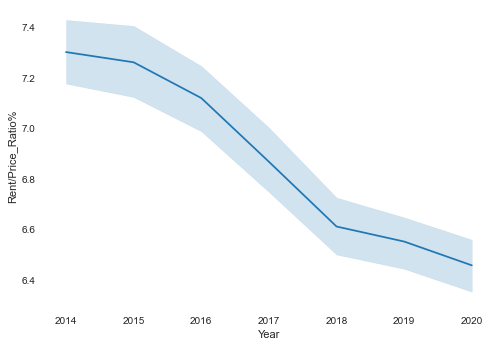

In [84]:
#plot rent/price ratios by year
sns.lineplot(data=df14_20, x="Year", y="Rent/Price_Ratio%")

<AxesSubplot:xlabel='Year', ylabel='Rent/PriceRatio_vacancyAdjusted%'>

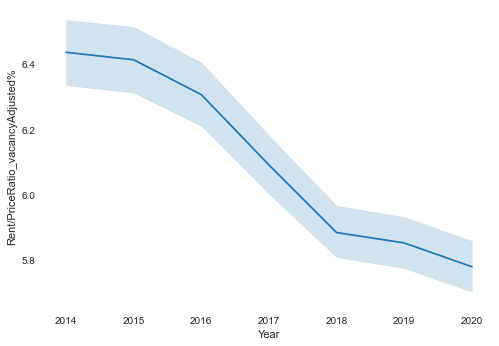

In [86]:
#plot rent/price ratio vacancy adjusted by year
sns.lineplot(data=df14_20, x="Year", y="Rent/PriceRatio_vacancyAdjusted%")

<AxesSubplot:xlabel='Year', ylabel='diff_Rent/Price_Ratios'>

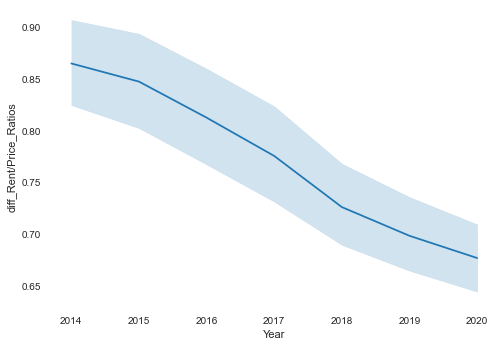

In [87]:
#plot difference of rent/price ratio AND rent/price vacancy adjusted ratios by year
sns.lineplot(data=df14_20, x="Year", y="diff_Rent/Price_Ratios")

In [311]:
#try and plot all 3 stds on one axis

#dfstd = df_std.melt('Year', var_name='cols',  value_name='vals')
#g = sns.factorplot(x="Year", y="vals", hue='cols', data=dfstd)

## Summary

##### NOTE THIS IS NOT REPRESENTATIVE OF ALL ZIPCODES B/C Zillow only had ~3000 zipcodes with rent prices vs. ~33k with home prices
**Therefore the data is most likely representative of more dense areas due to those areas having Zillow rental price data (ie. cities etc.**

- loaded data, model and refit model with all available data (2014-2018)
- performed 5 fold cross validation on all available data
    - mean test cv score: 0.95
    - std. test cv score: 0.03
    - mean absolute error: 1.15, std: 0.25

Calculated Expected Vacacny Rate for 2019-2020 From The Model
- dropped NaN rows in 2019-2020 data, for only the rows where vacacny is NOT NaN
- create X and y variables for years 2019-2020
- turned categorical variables into binary for predicting with get dummies
- predicted the vacancy rates for 2019-2020
- added 2019-2020 vacancy rate data to rest of 2019-2020 dataframe

Explored 2019-2020 Vacancy Rate Data
- saw number of unique States in 2019-2020 Vacancy Rate Data was 43
- examined states and determined missing states were AK, ME, MT, ND, SD, VT, WV, and WY
- split 2019-2020 data into separate years for more specific analysis
- looked at highest/lowest 2020 vacancy rate by:
    - zipcode
    - State
    - County
    - Metro Area
    - City
    
Explored 2020 Vacancy Rate Data  
- calculated rent to price ratio for each zipcode 
- calculated rent to price ratio adjusted for vacancy for each zipcode (aka potential strong/weak places to invest)
    - looked at highest/lowest by:
        - zipcode
        - State
        - County
        - Metro Area
        - City
- calculate difference from rent/price and rent/price vacancy adjusted ratios for each zipcode
Explore 2020 Places where Rent/Price Ratio Most Impacted by Vacancy¶
- looked at highest/lowest by:
     - zipcode
     - State
     - County
     - Metro Area
     - City
- seems zipcodes highest affected may be vacation areas?
    

***Note: Rent/Price ratios are only one factor when looking for potential areas to invest, one would also want to consider a variety of other factors (ie. unemployment, crime rate, job/population growth, etc)***


Combine 2014-2018 & 2019-2020 Data for exploration
- loaded 2014-2018 data without dummy variables and cleaned it
- concated 2014-2018 data with 2019-2020
- plot average vacany rate over time
    - lineplot of 2019-2020 predictions seems to roughly follow trend of 2019-2020 national data
- examined avg vacancy rate, rent price, and home price vs. years 2014-2020
- plotted mean and std of those 3 variables
    - over time the mean of home prices and rent prices increased while vacancy rate mean decreased
    - over time the std of rent prices and vacancy rate decreased while home prices increased
        - suggesting a trend of less variation from 2014-2020 in rent prices and vacancy rates and more variation in home prices. This seems to make sense in today's current market where in some areas home prices have increased rapidly during covid-19 pandemic and others areas have rapidly decreased.
        
Rent to Price Ratios over Time (2014-2020)
- calculated rent to price ratio for each zipcode
- calculated rent to price ratio adjusted for vacancy for each zipcode (aka potential strong/weak places to invest)
- calculate difference from rent/price and rent/price vacancy adjusted ratios for each zipcode
- plotted rent/price ratios by year
- plotted rent/price ratios adjusted for vacancy by year
- plotted difference from rent/price and rent/price vacancy adjusted ratios by year

**seems that the US as a whole has gotten a harder place to find good investments, even as rent prices have increased and vacacny rates have decreased. Potentialy this is due to home prices having increased faster than rent prices**

**also seems that vacacny rate has less of an impact on rent/price ratios over 2014-2020 across the US**

## Further Work

- We are MISSING LOTS OF ZIPCODES AND STATES
    - Missing States: AK, ME, MT, ND, SD, VT, WV, WY
- need to go back and deal with NaNs better to preserve more zipcodes (instead of just dropping only all NaN)
    - potential solution is to groupby year, and then linear fill?

- need to add in other zipcodes (get rent data from ACS)
    - for zillow rental price NaNs need to get rental data from ACS and predict 2019-2020 rent prices using another model (shouldn't be hard because home prices are so correlated, and we have current home prices for ~30k zipcodes from zillow
- could add in other variables to find areas to invest (ie. crime rates, unemployment rates, etc.)